In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import time

np.random.seed(42)

NOISE_SCALE = 0.25      
N_COMPONENTS = 400       
NYSTROEM_COMPONENTS = 2000 
GAMMA = 0.001            

# Data Loading & Preprocessing

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

X_train = train_dataset.data.numpy().astype(np.float32) / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)

X_test = test_dataset.data.numpy().astype(np.float32) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1)

y_test = test_dataset.targets.numpy()
vis_indices = []
for i in range(10):
    vis_indices.append(np.where(y_test == i)[0][0])

X_vis_clean = X_test[vis_indices]

print(f"Training Data Shape: {X_train.shape}")
print(f"Visualization Data Shape: {X_vis_clean.shape}")

Training Data Shape: (60000, 784)
Visualization Data Shape: (10, 784)


# Noise Injection & Visualization

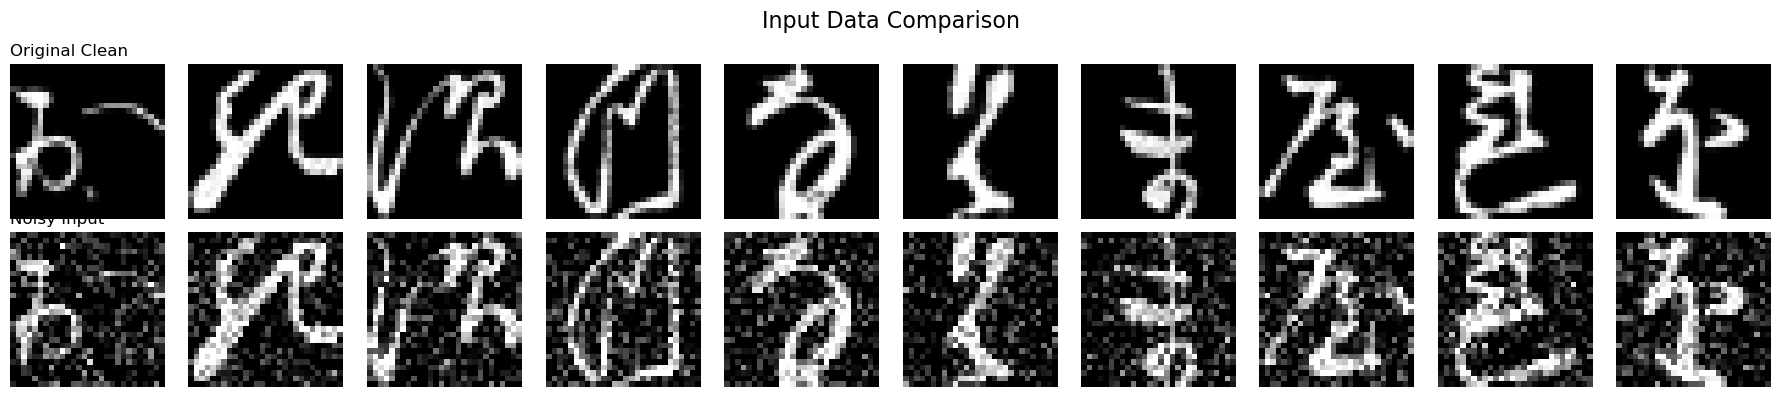

In [3]:
X_train_noisy = X_train + np.random.normal(0, NOISE_SCALE, X_train.shape)
X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0) 

X_vis_noisy = X_vis_clean + np.random.normal(0, NOISE_SCALE, X_vis_clean.shape)
X_vis_noisy = np.clip(X_vis_noisy, 0.0, 1.0)

def plot_inputs(clean, noisy):
    fig, axes = plt.subplots(2, 10, figsize=(18, 4))
    plt.suptitle("Input Data Comparison", fontsize=16)
    
    for i in range(10):
        axes[0, i].imshow(clean[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Original Clean", fontsize=12, loc='left')
        
        axes[1, i].imshow(noisy[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("Noisy Input", fontsize=12, loc='left')
    
    plt.tight_layout()
    plt.show()

plot_inputs(X_vis_clean, X_vis_noisy)

# Method 1 - Standard Linear PCA

Running Linear PCA on full dataset (60000 samples)...
PCA Done in 0.76 seconds.


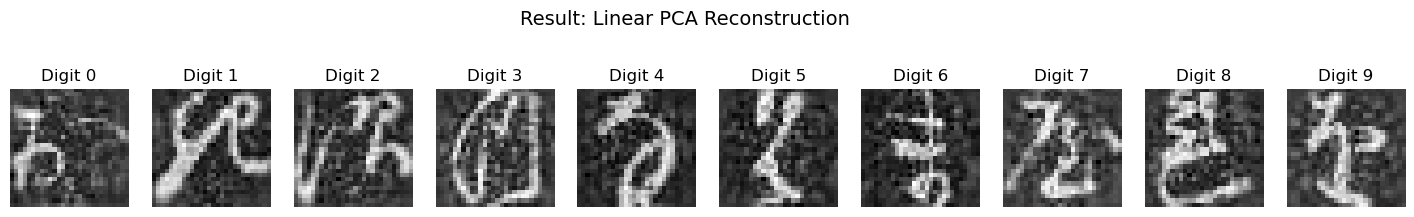

In [4]:
print(f"Running Linear PCA on full dataset ({X_train.shape[0]} samples)...")
start_time = time.time()

pca_linear = PCA(n_components=N_COMPONENTS)
pca_linear.fit(X_train_noisy)

X_recon_pca = pca_linear.inverse_transform(pca_linear.transform(X_vis_noisy))

print(f"PCA Done in {time.time() - start_time:.2f} seconds.")

def plot_single_row(images, title):
    fig, axes = plt.subplots(1, 10, figsize=(18, 2.5))
    fig.suptitle(title, fontsize=14, y=1.05)
    for i in range(10):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Digit {i}")
    plt.show()

plot_single_row(X_recon_pca, "Result: Linear PCA Reconstruction")

# Method 2 - Standard Kernel PCA (Subset Only)

Running Standard KPCA (RBF) on subset (2000 samples)...
Note: This uses sklearn's approximate inverse transform.
Standard KPCA Done in 1.45 seconds.


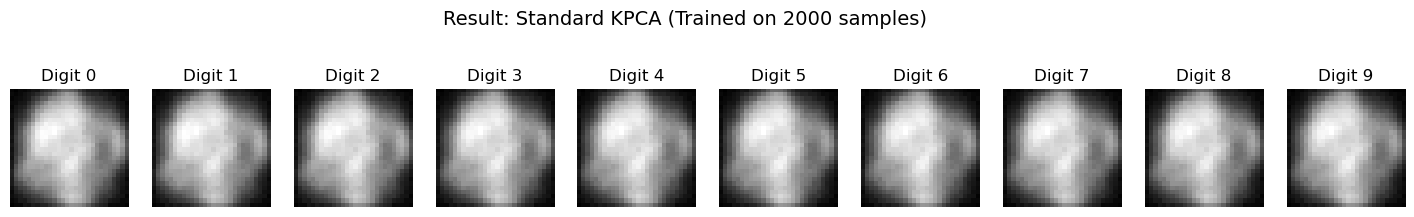

In [5]:
SUBSET_SIZE = 2000
print(f"Running Standard KPCA (RBF) on subset ({SUBSET_SIZE} samples)...")
print("Note: This uses sklearn's approximate inverse transform.")
start_time = time.time()

kpca_standard = KernelPCA(n_components=N_COMPONENTS, kernel='rbf', gamma=GAMMA, fit_inverse_transform=True)
kpca_standard.fit(X_train_noisy[:SUBSET_SIZE]) 

X_recon_kpca_std = kpca_standard.inverse_transform(kpca_standard.transform(X_vis_noisy))

print(f"Standard KPCA Done in {time.time() - start_time:.2f} seconds.")

plot_single_row(X_recon_kpca_std, f"Result: Standard KPCA (Trained on {SUBSET_SIZE} samples)")

# Method 3 - Scalable KPCA (Nystroem + Ridge Regression)

Running Scalable KPCA (Nystroem) on FULL dataset (60000 samples)...
Scalable KPCA Done in 30.74 seconds.


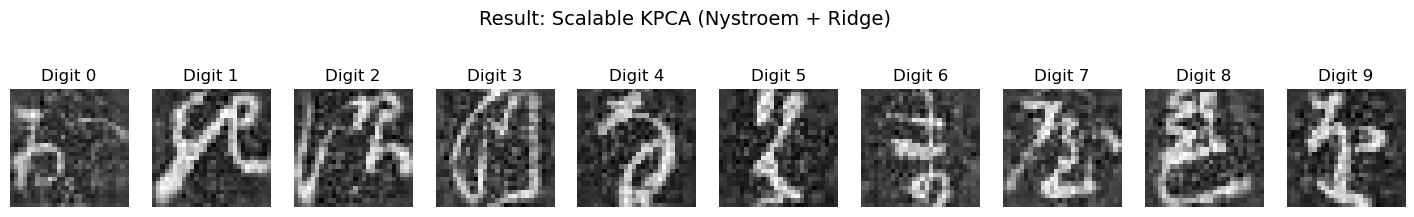

In [6]:
print(f"Running Scalable KPCA (Nystroem) on FULL dataset ({X_train.shape[0]} samples)...")
start_time = time.time()

feature_map = Nystroem(gamma=GAMMA, n_components=NYSTROEM_COMPONENTS, random_state=42)
scaler = StandardScaler()

X_features_train = feature_map.fit_transform(X_train_noisy)
X_features_train = scaler.fit_transform(X_features_train)

kpca_reducer = PCA(n_components=N_COMPONENTS)
X_reduced_train = kpca_reducer.fit_transform(X_features_train)

preimage_model = Ridge(alpha=0.1)
preimage_model.fit(X_reduced_train, X_train_noisy)


X_feat_vis = feature_map.transform(X_vis_noisy)
X_feat_vis = scaler.transform(X_feat_vis)

X_reduced_vis = kpca_reducer.transform(X_feat_vis)

X_recon_nystroem = preimage_model.predict(X_reduced_vis)

print(f"Scalable KPCA Done in {time.time() - start_time:.2f} seconds.")

plot_single_row(X_recon_nystroem, "Result: Scalable KPCA (Nystroem + Ridge)")

# Final Comparison & MSE Calculation

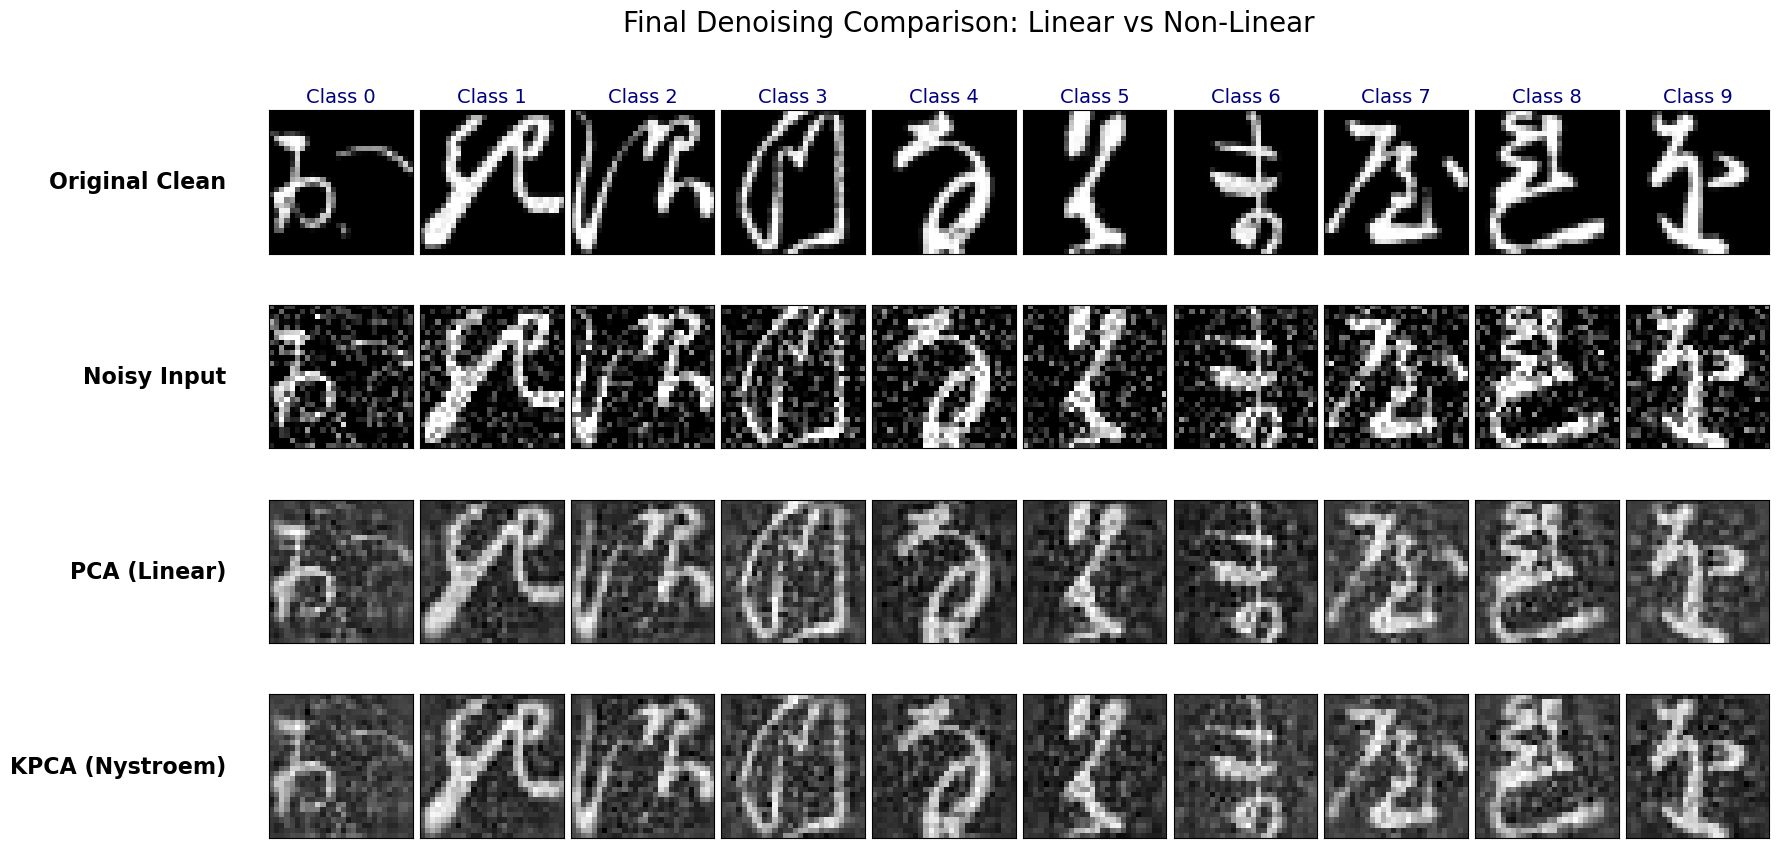

----------------------------------------
Reconstruction MSE (Lower is better):
1. Linear PCA:              0.02442
2. Standard KPCA (Subset):  0.10999
3. Scalable KPCA (Full):    0.02501
----------------------------------------


In [8]:
def plot_final_comparison(originals, noisy, recon_pca, recon_kpca_nys):
    n = len(originals)
    data_rows = [originals, noisy, recon_pca, recon_kpca_nys]
    row_labels = ["Original Clean", "Noisy Input", "PCA (Linear)", "KPCA (Nystroem)"]
    
    fig, axes = plt.subplots(4, n, figsize=(20, 10))
    plt.suptitle("Final Denoising Comparison: Linear vs Non-Linear", fontsize=20, y=0.96)
    
    for i in range(4):
        for j in range(n):
            ax = axes[i, j]
            img = data_rows[i][j].reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            
            # عنوان ستون‌ها (کلاس‌ها)
            if i == 0:
                ax.set_title(f"Class {j}", fontsize=14, color='navy')
            
            # عنوان ردیف‌ها (نام روش)
            if j == 0:
                ax.text(-0.3, 0.5, row_labels[i], transform=ax.transAxes, 
                        va='center', ha='right', fontsize=16, fontweight='bold', rotation=0)
                
    plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.15)
    plt.show()

plot_final_comparison(X_vis_clean, X_vis_noisy, X_recon_pca, X_recon_nystroem)

mse_pca = np.mean((X_vis_clean - X_recon_pca) ** 2)
mse_kpca_std = np.mean((X_vis_clean - X_recon_kpca_std) ** 2)
mse_kpca_nys = np.mean((X_vis_clean - X_recon_nystroem) ** 2)

print("-" * 40)
print(f"Reconstruction MSE (Lower is better):")
print(f"1. Linear PCA:              {mse_pca:.5f}")
print(f"2. Standard KPCA (Subset):  {mse_kpca_std:.5f}")
print(f"3. Scalable KPCA (Full):    {mse_kpca_nys:.5f}")
print("-" * 40)